In [ ]:
!pip install pmdarima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import plotly.express as px
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics import tsaplots
from pmdarima.arima import auto_arima
from datetime import datetime, timedelta
import warnings
from itertools import product
from scipy import stats

In [ ]:
gold_df = pd.read_csv('/content/drive/MyDrive/Gold_One_Day.csv')
gold_df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,00:00,384.0,384.8,382.8,384.1,272
1,2004.06.14,00:00,384.3,385.8,381.8,382.8,1902
2,2004.06.15,00:00,382.8,388.8,381.1,388.6,1951
3,2004.06.16,00:00,387.1,389.8,382.6,383.8,2014
4,2004.06.17,00:00,383.6,389.3,383.0,387.6,1568


In [ ]:
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
gold_df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2004-06-11,00:00,384.0,384.8,382.8,384.1,272
1,2004-06-14,00:00,384.3,385.8,381.8,382.8,1902
2,2004-06-15,00:00,382.8,388.8,381.1,388.6,1951
3,2004-06-16,00:00,387.1,389.8,382.6,383.8,2014
4,2004-06-17,00:00,383.6,389.3,383.0,387.6,1568


In [ ]:
gold_df.set_index('Date', inplace=True)
gold_df.head()

,Time,Open,High,Low,Close,Volume
Date,,,,,,
2004-06-11,00:00,384.0,384.8,382.8,384.1,272
2004-06-14,00:00,384.3,385.8,381.8,382.8,1902
2004-06-15,00:00,382.8,388.8,381.1,388.6,1951
2004-06-16,00:00,387.1,389.8,382.6,383.8,2014
2004-06-17,00:00,383.6,389.3,383.0,387.6,1568


In [ ]:
fig = px.line(gold_df,
              x=gold_df.index,
              y='Close',
              title = "Price of Gold 2004-2024"
              )
fig.show()

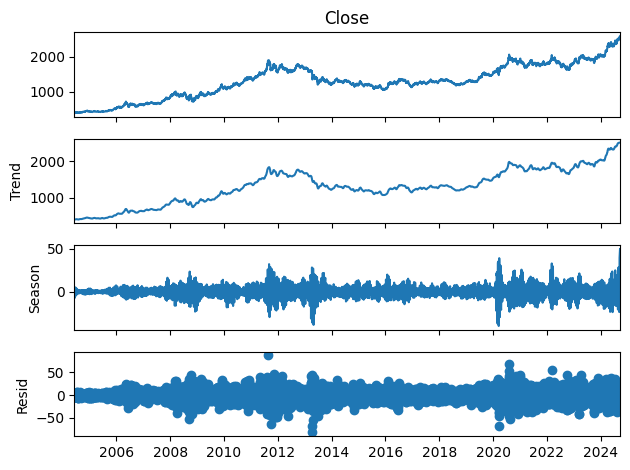

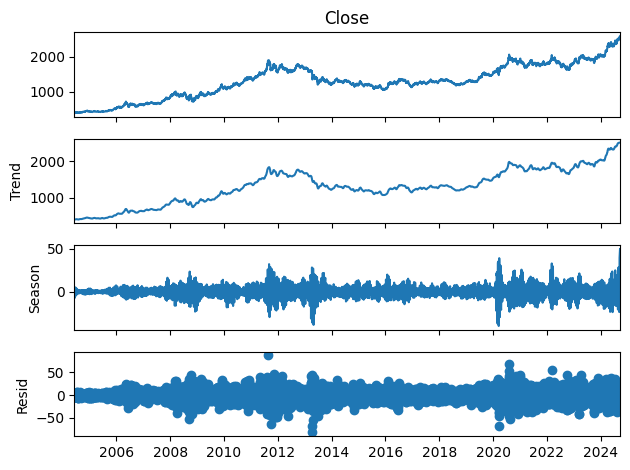

In [ ]:
stl = tsa.STL(gold_df['Close'], period=12).fit()
stl.plot()

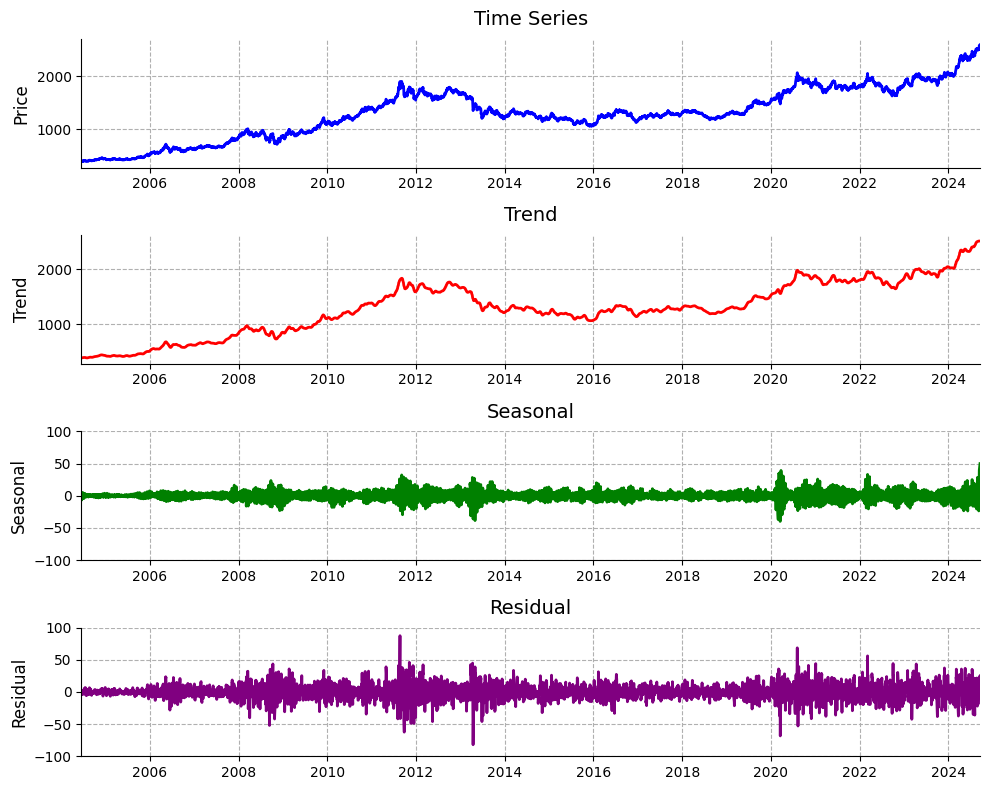

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(10,8))
fig.set_facecolor('w')

ax0.plot(gold_df.index, gold_df['Close'], color='blue', linewidth=2)
ax0.set_title("Time Series", fontsize=14, pad=10)

ax1.plot(gold_df.index, stl.trend, color='red', linewidth=2)
ax1.set_title("Trend", fontsize=14, pad=10)

ax2.plot(gold_df.index, stl.seasonal, color='green', linewidth=2)
ax2.set_title("Seasonal", fontsize=14, pad=10)

ax3.plot(gold_df.index, stl.resid, color='purple', linewidth=2)
ax3.set_title("Residual", fontsize=14, pad=10)

for ax in (ax0, ax1, ax2, ax3):
  #Styling of the Grid
  ax.grid(True, linestyle='--')

  #Borders
  for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

  #Tick Parameters
  ax.tick_params(labelsize=10)

  #Background color
  ax.set_facecolor('white')

  ax.set_xlim(gold_df.index[1], gold_df.index[-1])

for ax in [ax2, ax3]:
  ax.set_ylim(-100,100)

ax0.set_ylabel('Price', fontsize=12)
ax1.set_ylabel('Trend', fontsize=12)
ax2.set_ylabel('Seasonal', fontsize=12)
ax3.set_ylabel('Residual', fontsize=12)


plt.tight_layout()

In [ ]:
#Determining stationarity by implementing Augmented Dickey Fuller Test
adf = tsa.adfuller(gold_df['Close'])
print(f"ADF Statistic: {adf[0]}")
print(f"p-value: {adf[1]}")

ADF Statistic: -0.17692482646758603
p-value: 0.9412168046253429


In [ ]:
#Not Stationary so we must difference it
gold_diff = gold_df['Close'].diff(periods=12)
gold_diff = gold_diff.diff(periods=1)
gold_diff.dropna(inplace=True)
adf_diff = tsa.adfuller(gold_diff)
print(f"ADF Statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}")


ADF Statistic: -21.86800045441902
p-value: 0.0


In [ ]:
#Must apply Box Cox Transformation in order to transform the non-normally distributed data into normally distributed data
#Normalizes skewed data
#Select only numeric columns for resampling before applying boxcox
gold_df_month = gold_df.select_dtypes(include=np.number).resample('ME').mean()
gold_df_month['Close'], lmbda = stats.boxcox(gold_df_month.Close)
print(f'The Dickey Fuller Test is {sm.tsa.stattools.adfuller(gold_df_month["Close"])[1]}')
print('Non stationary')

The Dickey Fuller Test is 0.9341061619698158
Non stationary


In [ ]:
#After applying the Box Cox transformation for the Dickey Fuller Test, we can inverse it to get the unnormalized the original data
def invboxcox(y, lmbda):
  if lmbda == 0:
    return(np.exp(y))
  else:
    return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
# Select only numeric columns for resampling
gold_df_month = gold_df.select_dtypes(include=np.number).resample('ME').mean()
gold_df_day = gold_df.select_dtypes(include=np.number).resample('D').mean()
gold_df_year = gold_df.select_dtypes(include=np.number).resample('YE').mean()
gold_df_month.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-06-30,391.471429,395.071429,389.085714,392.185714,1778.785714
2004-07-31,397.652381,400.623810,394.404762,397.638095,1659.047619
2004-08-31,400.140909,403.240909,397.736364,401.063636,1840.136364
2004-09-30,405.109524,407.528571,402.680952,405.700000,2240.333333
2004-10-31,420.109524,422.785714,417.661905,420.695238,1231.285714


In [ ]:
#Set up parameter ranges for the SARIMAX grid search
Qs = range(0,2) #seasonal AR order
qs = range(0,3) #non-seasonal AR order
Ps = range(0,3) #Seasonal MA order
ps = range(0,3) #non-seasonal MA order

#Seasonal difference (D) and non-seasonal difference (d) values
D = 1
d = 1

#Generate all combinations of parameters for the SARIMAX
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

#initialize variables to store the best model and results
best_aic = float('inf')
best_model = None
best_param = None
results = []

#Suppress warnings during the search
warnings.filterwarnings('ignore')

#Grid search for best and most optimal SARIMAX parameters
for param in parameters_list:
  try:
    #Fit the SARIMAX with current parameter combination
    model = sm.tsa.statespace.SARIMAX(gold_df_month['Close'], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #Extract the AIC
    aic = model.aic
    #If current model has a lower AIC, update the model
    if aic < best_aic:
      best_aic = aic
      best_model = model
      best_param = param


    results.append([param, aic])

  except ValueError as e:
    print(f"Error with parameters {param}: {e}")
    continue

#Display best parameter combination and corresponding AIC
print(f"Best Parameters: {best_param}")
print(f"Best AIC: {best_aic}")


Best Parameters: (0, 1, 0, 1)
Best AIC: 2465.8348430215974


In [ ]:
gold_df_month2 = gold_df_month[['Close']]
start_date = datetime(2012,1,1)
end_date = datetime(2026,3,31)
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

In [ ]:
future = pd.DataFrame(index=date_range, columns=gold_df_month.columns)
gold_df_month2 = pd.concat([gold_df_month2, future])

In [ ]:
gold_df_month2['forecast'] = invboxcox(best_model.predict(start=len(gold_df_month2)-len(future), end=len(gold_df_month2)-1), lmbda)

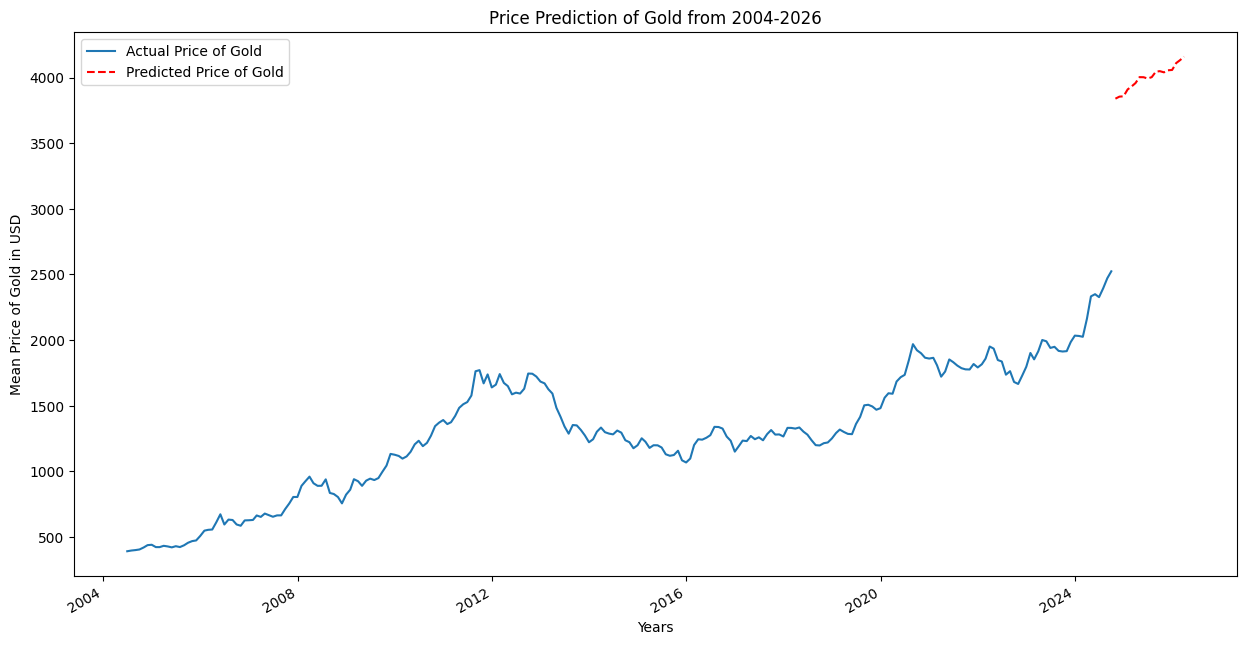

In [ ]:
plt.figure(figsize=(15,8))
gold_df_month2['Close'].plot(label='Actual Price of Gold')
gold_df_month2['forecast'].plot(color='r', ls='--', label='Predicted Price of Gold')
plt.legend()
plt.title("Price Prediction of Gold from 2004-2026")
plt.ylabel('Mean Price of Gold in USD')
plt.xlabel('Years')
plt.show()


future = pd.DataFrame(index=date_range, columns=gold_df_month.columns)
gold_df_month2 = pd.concat([gold_df_month2, future])

gold_df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=len(gold_df_month2)-1), lmbda)